In [6]:
import pandas as pd 
import numpy as np
import math
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import plot
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform, pdist
import plotly.express as px
import sys

np.random.seed(1234)


def make_piecharts(data_df, n_rows, n_cols, fig_title):
    specs_list = []
    subplot_coordinate = []
    for x in range(n_rows):
        temp_spec_list = []
        for  y in range(n_cols):
            temp_spec_list.append({"type": "pie"})
            subplot_coordinate.append([x+1, y+1])
        specs_list.append(temp_spec_list)
    fig = make_subplots(rows=n_rows, cols=n_cols, specs=specs_list, subplot_titles= list(data_df["sample"]))
    for i in range(data_df.shape[0]):
        df = pd.DataFrame(data_df.iloc[i,1:])
        sample_name = data_df.iloc[i,:][0]
        df.rename( columns={i : sample_name}, inplace = True)
        fig.add_trace(go.Pie(labels=list(df[sample_name].index), values= df[sample_name].values, name=sample_name, textinfo= "none"), subplot_coordinate[i][0] , subplot_coordinate[i][1] )
    fig.update_layout(width = 2000, height = 2000, title_text=fig_title)
    return fig


def add_scatterplot_layer(data_df, _color , fig ): 
    try:
        data_df["sample"] = [ i.split("_")[0].split(".")[0] for i in data_df["sample"]]
    except:
        pass
    for i in range(len(data_df)):
        fig.add_trace(go.Scatter( name = data_df.iloc[i]["sample"] , legendgroup=data_df.iloc[i]["sample"] ,  marker=dict(color= _color), x = data_df.columns[1:], y = data_df.iloc[i, 1:], mode='markers') )

r_output_file_dir = sys.argv[1]
r_output_file_dir = "test_results"

def run_legacy(sigfit = True, sigflow = True, deconstructSigs= True, mutationalPattern = True):

    try:
        deconstructisgs_legacy_drop_list = ["Signature.1", "Signature.5", "Signature.12"]
        artefacts_cosmic_sigs_sigfit = ["mean.Signature.1", "mean.Signature.5", "mean.Signature.12"]
        artefacts_sbs_sigs_sigfit = ["mean.SBS1","mean.SBS5","mean.SBS27","mean.SBS43","mean.SBS45","mean.SBS46","mean.SBS47","mean.SBS48","mean.SBS49","mean.SBS50","mean.SBS51","mean.SBS52","mean.SBS53","mean.SBS54","mean.SBS55","mean.SBS56","mean.SBS57","mean.SBS58","mean.SBS59","mean.SBS60"]
        legacy_error_list = []
        legacy_rmse_name_list = []
        if sigflow:
            siglfow_legacy_errors_df = pd.read_csv(r_output_file_dir + "/sigflow/legacy_fitting_reconstruction_errors.csv")
            legacy_error_list.append(siglfow_legacy_errors_df.iloc[:,1])
            legacy_rmse_name_list.append("sigflow")
        if sigfit:
            sigfit_legacy_errors_df = pd.read_csv(r_output_file_dir + "/sigfit_results/sample_errors_legacy.csv")
            legacy_error_list.append(sigfit_legacy_errors_df.iloc[:,1])
            legacy_rmse_name_list.append("sigfit")
        if mutationalPattern:
            mutational_pattern_strict_legacy_errors_df = pd.read_csv(r_output_file_dir +"/mutational_patterns_results/legacy_strict_sample_errors.csv")
            mutational_pattern_legacy_errors_df = pd.read_csv(r_output_file_dir + "/mutational_patterns_results/legacy_sample_errors.csv")
            legacy_error_list.append(mutational_pattern_strict_legacy_errors_df.iloc[:,1])
            legacy_rmse_name_list.append("mutationalPatterns_strict")
            legacy_error_list.append(mutational_pattern_legacy_errors_df.iloc[:,1])
            legacy_rmse_name_list.append("mutationalPatterns")
        if deconstructSigs:
            deconstruct_legacy_errors_df = pd.read_csv(r_output_file_dir + "/deconstructsigs_results/legacy_sample_errors.csv")
            legacy_error_list.append(deconstruct_legacy_errors_df.iloc[:,1])
            legacy_rmse_name_list.append("deconstructSigs")
        legacy_rmse_list = []
        for i in legacy_error_list:
            MSE = np.square(i).mean() 
            RMSE = math.sqrt(MSE)
            legacy_rmse_list.append(RMSE)
            
        legacy_rmse_df = pd.DataFrame(legacy_rmse_list, index=legacy_rmse_name_list)
        legacy_rmse_df.columns = ["RMSE"]
        legacy_rmse_df["toolname"] = legacy_rmse_name_list
        legacy_rmse_df.to_csv(r_output_file_dir + "/legacy_rmse_data.csv")
        fig = px.bar(legacy_rmse_df, x= "toolname" , y='RMSE', title="RMSE of reconstruction error using COSMIC legacy signatures")
        fig.write_image(r_output_file_dir +"/legacy_rmse_bar_plot.pdf")
        
        legacy_df_list = []
        legacy_df_name_list = []
        if sigflow:
            sigflow_legacy_exposure_df = pd.read_csv(r_output_file_dir + "/sigflow/legacy_fitting_relative_exposure.csv")
            pie_chart_rows = math.ceil(sigflow_legacy_exposure_df.shape[0] / 3) 
            pie_chart_cols = 3
            sigflow_legacy_exposure_df_fig = make_piecharts(sigflow_legacy_exposure_df, pie_chart_rows, pie_chart_cols, "COSMIC V2 'Legacy' exposures data Sigflow")    
            legacy_df_list.append(sigflow_legacy_exposure_df.sort_values(by=["sample"]))
            legacy_df_name_list.append("sigflow")
        if mutationalPattern:
            mutationalPatterns_legacy_exposure_df = pd.read_csv(r_output_file_dir + "/mutational_patterns_results/legacy_sample_exposures.csv")
            mutationalPatterns_legacy_exposure_df = mutationalPatterns_legacy_exposure_df.rename(columns={"Unnamed: 0": "sample"})
            mutationalPatterns_legacy_exposure_df.set_index("sample", inplace = True)
            mutationalPatterns_legacy_exposure_df = mutationalPatterns_legacy_exposure_df.div(mutationalPatterns_legacy_exposure_df.sum(axis=1), axis=0)
            mutationalPatterns_legacy_exposure_df.reset_index(inplace= True)

            mutationalPatterns_strict_legacy_exposure_df = pd.read_csv(r_output_file_dir + "/mutational_patterns_results/legacy_strict_sample_exposures.csv")
            mutationalPatterns_strict_legacy_exposure_df = mutationalPatterns_strict_legacy_exposure_df.rename(columns={"Unnamed: 0": "sample"})
            mutationalPatterns_strict_legacy_exposure_df.set_index("sample", inplace = True)
            mutationalPatterns_strict_legacy_exposure_df = mutationalPatterns_strict_legacy_exposure_df.div(mutationalPatterns_strict_legacy_exposure_df.sum(axis=1), axis=0)
            mutationalPatterns_strict_legacy_exposure_df.reset_index(inplace= True)

            mutationalPatters_legacy_fig = make_piecharts(mutationalPatterns_legacy_exposure_df, pie_chart_rows, pie_chart_cols, "COSMIC V2 'Legacy' exposures  data MutationalPatterns")    
            mutationalPatters_strict_legacy_fig = make_piecharts(mutationalPatterns_strict_legacy_exposure_df, pie_chart_rows, pie_chart_cols, "COSMIC V2 'Legacy' exposures data MutationalPatterns Strict")                
            legacy_df_list.append(mutationalPatterns_legacy_exposure_df.sort_values(by=["sample"]))
            legacy_df_name_list.append("mutationalPatterns")
            legacy_df_list.append(mutationalPatterns_strict_legacy_exposure_df.sort_values(by=["sample"]))
            legacy_df_name_list.append("mutationalPatterns_strict")
        if deconstructSigs:
            deconstructSigs_legacy_exposure_df = pd.read_csv(r_output_file_dir + "/deconstructsigs_results/legacy_sample_exposures.csv")
            deconstructSigs_legacy_exposure_df.rename( columns = {"Unnamed: 0": "sample"}, inplace= True)
            deconstructSigs_legacy_exposure_df_fig = make_piecharts(deconstructSigs_legacy_exposure_df, pie_chart_rows, pie_chart_cols, "COSMIC V2 'Legacy' exposures data DeconstructSigs")    
            legacy_df_list.append(deconstructSigs_legacy_exposure_df.sort_values(by=["sample"]))
            legacy_df_name_list.append("deconstructSigs")
        if sigfit:
            sigfit_legacy_exposure_df = pd.read_csv(r_output_file_dir + "/sigfit_results/sample_exposures_legacy.csv")
            sigfit_legacy_exposure_df.rename(columns={"Unnamed: 0": "sample" }, inplace= True)
            sigfit_legacy_exposure_df.columns = ["sample"] +  [ "COSMIC_" + i.split(".")[-1] for i in sigfit_legacy_exposure_df.columns[1:]]
            sigfit_legacy_exposure_df_fig = make_piecharts(sigfit_legacy_exposure_df, pie_chart_rows, pie_chart_cols, "COSMIC V2 'Legacy' exposures  data Sigfit")    
            legacy_df_list.append(sigfit_legacy_exposure_df.sort_values(by=["sample"]))
            legacy_df_name_list.append("sigfit")

        with open(r_output_file_dir + '/legacy_pie_charts.html', 'a') as f:
            if sigflow:
                f.write(sigflow_legacy_exposure_df_fig.to_html(full_html=False, include_plotlyjs='cdn'))
            if mutationalPattern:
                f.write(mutationalPatters_legacy_fig.to_html(full_html=False, include_plotlyjs='cdn'))
                f.write(mutationalPatters_strict_legacy_fig.to_html(full_html=False, include_plotlyjs='cdn'))
            if sigfit:
                f.write(sigfit_legacy_exposure_df_fig.to_html(full_html=False, include_plotlyjs='cdn'))
            if deconstructSigs:
                f.write(deconstructSigs_legacy_exposure_df_fig.to_html(full_html=False, include_plotlyjs='cdn'))

        distance_df_list = []
        for i in range(legacy_df_list[0].shape[0]):
            temp_df = []
            for index , j in enumerate(legacy_df_list):
                j.iloc[i,0] = legacy_df_name_list[index]
                temp_df.append(list(j.iloc[i,:]))
            _df = pd.DataFrame(temp_df, columns = legacy_df_list[0].columns)
            _df.fillna(0, inplace = True)
            distance_df_list.append(_df)

        fig = plt.figure(figsize=(30, 30))
        fig.subplots_adjust(hspace=2, wspace=2)
        rows = math.ceil(sigflow_legacy_exposure_df.shape[0] / 6)
        columns = 6
        for i in range(len(distance_df_list)):
            df = distance_df_list[i]
            df__ = pd.DataFrame(squareform(pdist(df.iloc[:, 1:])), columns=df["sample"].unique(), index=df["sample"].unique())
            sns.set()
            ax = fig.add_subplot(rows, columns, i+1)    
            sns.heatmap(df__)
            plt.title("Heatmap legacy " + sigflow_legacy_exposure_df.iloc[i,0] )
        plt.savefig(r_output_file_dir + "/Heatmap_legacy.pdf", dpi =500)

        fig = plt.figure(figsize=( 120, 30 ))
        fig.subplots_adjust(right = 0.9, wspace=.01)
        rows = 1
        columns = 5
        for i in range(len(legacy_df_list)):
            df = legacy_df_list[i]
            sns.set()
            ax = fig.add_subplot(rows, columns, i+1)    
            sns.heatmap(df.set_index("sample") , cmap="YlGnBu" , xticklabels = True, yticklabels= True)
            sns.set(rc={'figure.figsize':(30, 30)})
            plt.title("Heatmap legacy " + legacy_df_name_list[i] )
        plt.savefig(r_output_file_dir + "/Heatmap_exposures_all_sigs_legacy.pdf")

    except Exception as e:
        print("No legacy sigs found")    
        print(e.__doc__)
        print(e.message)
        pass    

def run_sbs():
    try:
        sigflow_sbs_errors_df = pd.read_csv(r_output_file_dir+ "/sigflow/SBS_fitting_reconstruction_errors.csv")
        sigfit_sbs_errors_df = pd.read_csv(r_output_file_dir + "/sigfit_results/sample_errors_sbs.csv")
        mutational_pattern_strict_sbs_errors_df = pd.read_csv(r_output_file_dir + "/mutational_patterns_results/strict_sample_errors.csv")
        mutational_pattern_sbs_errors_df = pd.read_csv(r_output_file_dir + "/mutational_patterns_results/sample_errors.csv")
        deconstruct_sbs_errors_df = pd.read_csv(r_output_file_dir +"/deconstructsigs_results/sbs_sample_errors.csv")
        sbs_error_list = [sigflow_sbs_errors_df.iloc[:,1] ,  sigfit_sbs_errors_df.iloc[:,1] , mutational_pattern_strict_sbs_errors_df.iloc[:,1] , mutational_pattern_sbs_errors_df.iloc[:,1] ,  deconstruct_sbs_errors_df.iloc[:,1] ]
        sbs_rmse_name_list = ["sigflow", "sigfit", "mutationalPatterns_strict", "mutationalPatterns" , "deconstructSigs"]
        sbs_rmse_list = []
        for i in sbs_error_list:
            MSE = np.square(i).mean() 
            RMSE = math.sqrt(MSE)
            sbs_rmse_list.append(RMSE)
            
        sbs_rmse_df = pd.DataFrame(sbs_rmse_list, index=sbs_rmse_name_list)        
        sbs_rmse_df.columns = ["RMSE"]
        sbs_rmse_df.sort_values(by= ["RMSE"])
        sbs_rmse_df["toolname"] = sbs_rmse_name_list
        sbs_rmse_df.to_csv(r_output_file_dir + "/sbs_rmse_data.csv")
        fig = px.bar(sbs_rmse_df, x="toolname", y='RMSE', title="RMSE of reconstruction error using COSMIC SBS signatures")
        fig.write_image(r_output_file_dir + "/sbs_rmse_bar_plot.pdf")

        sigflow_sbs_exposure_df = pd.read_csv(r_output_file_dir + "/sigflow/SBS_fitting_relative_exposure.csv")
        pie_chart_rows = math.ceil(sigflow_sbs_exposure_df.shape[0] / 3) 
        pie_chart_cols = 3

        mutationalPatterns_sbs_exposure_df = pd.read_csv(r_output_file_dir + "/mutational_patterns_results/sample_exposures.csv")
        mutationalPatterns_sbs_exposure_df = mutationalPatterns_sbs_exposure_df
        mutationalPatterns_sbs_exposure_df.rename(columns={"Unnamed: 0": "sample"}, inplace = True)
        mutationalPatterns_sbs_exposure_df.set_index("sample", inplace = True)
        mutationalPatterns_sbs_exposure_df = mutationalPatterns_sbs_exposure_df.rename(columns={"index": "sample"})
        mutationalPatterns_sbs_exposure_df.sum(axis=1)
        mutationalPatterns_sbs_exposure_df = mutationalPatterns_sbs_exposure_df.div(mutationalPatterns_sbs_exposure_df.sum(axis=1), axis=0)
        mutationalPatterns_sbs_exposure_df.reset_index(inplace= True)

        mutationalPatterns_strict_sbs_exposure_df = pd.read_csv(r_output_file_dir + "/mutational_patterns_results/strict_sample_exposures.csv")
        mutationalPatterns_strict_sbs_exposure_df = mutationalPatterns_strict_sbs_exposure_df
        mutationalPatterns_strict_sbs_exposure_df.rename(columns={"Unnamed: 0": "sample"}, inplace = True)
        mutationalPatterns_strict_sbs_exposure_df.set_index("sample", inplace = True)
        mutationalPatterns_strict_sbs_exposure_df = mutationalPatterns_strict_sbs_exposure_df.rename(columns={"index": "sample"})
        mutationalPatterns_strict_sbs_exposure_df.sum(axis=1)
        mutationalPatterns_strict_sbs_exposure_df.div(mutationalPatterns_strict_sbs_exposure_df.sum(axis=1), axis=0)
        mutationalPatterns_strict_sbs_exposure_df.reset_index(inplace= True)

        deconstructSigs_sbs_exposure_df = pd.read_csv(r_output_file_dir + "/deconstructsigs_results/sbs_sample_exposures.csv")
        deconstructSigs_sbs_exposure_df.rename( columns = {"Unnamed: 0": "sample"}, inplace= True)

        sigfit_sbs_exposure_df = pd.read_csv(r_output_file_dir + "/sigfit_results/sample_exposures_sbs.csv")
        sigfit_sbs_exposure_df.rename(columns={"Unnamed: 0": "sample" }, inplace= True)

        sigflow_sbs_exposure_df_fig = make_piecharts(sigflow_sbs_exposure_df, pie_chart_rows, pie_chart_cols, "COSMIC V3 'SBS' exposures data Sigflow")   

        sbs_mutational_patters_fig = make_piecharts(mutationalPatterns_sbs_exposure_df, pie_chart_rows, pie_chart_cols, "COSMIC V3 'SBS' exposures  data MutationalPatterns")    
        sbs_mutational_patters_strict_fig = make_piecharts(mutationalPatterns_strict_sbs_exposure_df, pie_chart_rows, pie_chart_cols, "COSMIC V3 'SBS' exposures data MutationalPatterns Strict")    

        sigfit_sbs_exposure_df_fig = make_piecharts(sigfit_sbs_exposure_df, pie_chart_rows, pie_chart_cols, "COSMIC V3 'SBS' exposures data Sigfit")   

        deconstructSigs_sbs_exposure_df_fig = make_piecharts(deconstructSigs_sbs_exposure_df, pie_chart_rows, pie_chart_cols, "COSMIC V3 'Legacy' exposures data DeconstructSigs")    

        with open(r_output_file_dir + '/sbs_pie_charts.html', 'a') as f:
            f.write(sigflow_sbs_exposure_df_fig.to_html(full_html=False, include_plotlyjs='cdn'))
            f.write(sbs_mutational_patters_fig.to_html(full_html=False, include_plotlyjs='cdn'))        
            f.write(sbs_mutational_patters_strict_fig.to_html(full_html=False, include_plotlyjs='cdn'))           
            f.write(sigfit_sbs_exposure_df_fig.to_html(full_html=False, include_plotlyjs='cdn'))
            f.write(deconstructSigs_sbs_exposure_df_fig.to_html(full_html=False, include_plotlyjs='cdn'))


        sbs_df_list = [mutationalPatterns_sbs_exposure_df.sort_values(by=["sample"]), mutationalPatterns_strict_sbs_exposure_df.sort_values(by=["sample"]),  sigfit_sbs_exposure_df.sort_values(by=["sample"]), sigflow_sbs_exposure_df.sort_values(by=["sample"]), deconstructSigs_sbs_exposure_df.sort_values(by=["sample"]) ]
        sbs_df_name_list = [ "mutationalPatterns", "mutationalPatterns_strict" ,  "sigfit" , "sigflow" , "deconstructSigs"]
        distance_df_list = []
        for i in range(sbs_df_list[0].shape[0]):
            temp_df = []
            for index , j in enumerate(sbs_df_list):
                j["sample"] = sbs_df_name_list[index]
                temp_df.append(list(j.iloc[i,:]))
            _df = pd.DataFrame(temp_df, columns = sbs_df_list[3].columns)
            _df.fillna(0, inplace= True)
            distance_df_list.append(_df)

        fig = plt.figure(figsize=(30, 30))
        fig.subplots_adjust(hspace=2, wspace=2)
        rows = math.ceil(sigflow_sbs_exposure_df.shape[0] / 6) 
        columns = 6
        print(rows, columns)
        for i in range(len(distance_df_list)):  
            df = distance_df_list[i]
            df_ = pd.DataFrame(squareform(pdist(df.iloc[:, 1:])), columns=df["sample"].unique(), index=df["sample"].unique())
            sns.set()
            ax = fig.add_subplot(rows, columns, i+1)    
            sns.heatmap(df_)
            plt.title("Heatmap SBS " + str(sigfit_sbs_exposure_df.iloc[i,0]))
        plt.savefig(r_output_file_dir + "/Heatmap_SBS.pdf", dpi =500)


        sbs_df_list = [mutationalPatterns_sbs_exposure_df.sort_values(by=["sample"]), sigfit_sbs_exposure_df.sort_values(by=["sample"]), sigflow_sbs_exposure_df.sort_values(by=["sample"]), deconstructSigs_sbs_exposure_df.sort_values(by=["sample"]) ]
        sbs_df_name_list = [ "mutationalPatters",  "sigfit" , "sigflow" ,  "deconstructSigs"]
        fig = plt.figure(figsize=(120, 30))
        fig.subplots_adjust(right = 0.9, wspace=.01)
        rows = 1
        columns = 4
        for i in range(len(sbs_df_list)):  
            df = sbs_df_list[i].set_index("sample").astype(float)
            sns.set()
            ax = fig.add_subplot(rows, columns, i+1)
            sns.heatmap(df , cmap="YlGnBu", xticklabels = True, yticklabels= True )
            sns.set(rc={'figure.figsize':(30, 30)})
            plt.title("Heatmap SBS " + str(sbs_df_name_list[i]))
        plt.savefig(r_output_file_dir + "/Heatmap_exposures_all_sigs_SBS.pdf")

    except Exception as e:
        print("No SBS sigs found")    
        print(e.__doc__)
        print(e.message)
        pass

def run_id():
    try:
        siglfow_id_errors_df = pd.read_csv(r_output_file_dir + "/sigflow/ID_fitting_reconstruction_errors.csv")
        sigfit_id_errors_df = pd.read_csv(r_output_file_dir + "/sigfit_results/sample_errors_indel.csv")
        mutational_pattern_id_errors_df = pd.read_csv(r_output_file_dir + "/mutational_patterns_results/id_sample_errors.csv")
        deconstruct_id_errors_df = pd.read_csv(r_output_file_dir + "/deconstructsigs_results/indel_sample_errors.csv")
        id_error_list = [siglfow_id_errors_df.iloc[:,1] ,  sigfit_id_errors_df.iloc[:,1] , mutational_pattern_id_errors_df.iloc[:,1] ,  deconstruct_id_errors_df.iloc[:,1] ]
        id_rmse_name_list = ["sigflow", "sigfit",  "mutationalPatterns" , "deconstructSigs"]
        id_rmse_list = []
        for i in id_error_list:
            MSE = np.square(i).mean() 
            RMSE = math.sqrt(MSE)
            id_rmse_list.append(RMSE)
            
        id_rmse_df = pd.DataFrame(id_rmse_list, index=id_rmse_name_list)        
        id_rmse_df.columns = ["RMSE"]
        id_rmse_df.sort_values(by= ["RMSE"])
        id_rmse_df["toolname"] = id_rmse_name_list
        id_rmse_df.to_csv(r_output_file_dir + "/id_rmse_data.csv")
        fig = px.bar(id_rmse_df, x="toolname", y='RMSE', title="RMSE of reconstruction error using COSMIC ID signatures")
        fig.write_image(r_output_file_dir + "/id_rmse_bar_plot.pdf")

        sigflow_id_exposure_df = pd.read_csv(r_output_file_dir + "/sigflow/ID_fitting_relative_exposure.csv")
        pie_chart_rows = math.ceil(sigflow_id_exposure_df.shape[0] / 3) 
        pie_chart_cols = 3

        mutationalPatterns_id_exposure_df = pd.read_csv(r_output_file_dir + "/mutational_patterns_results/id_sample_exposures.csv")
        mutationalPatterns_id_exposure_df = mutationalPatterns_id_exposure_df.rename(columns={"Unnamed: 0": "sample"})
        mutationalPatterns_id_exposure_df.set_index("sample", inplace = True)
        mutationalPatterns_id_exposure_df = mutationalPatterns_id_exposure_df.div(mutationalPatterns_id_exposure_df.sum(axis=1), axis=0)
        mutationalPatterns_id_exposure_df.reset_index(inplace = True)
        
        
        deconstructSigs_id_exposure_df = pd.read_csv(r_output_file_dir + "/deconstructsigs_results/indel_sample_exposures.csv")
        deconstructSigs_id_exposure_df.rename( columns = {"Unnamed: 0": "sample"}, inplace= True)

        sigfit_id_exposure_df = pd.read_csv(r_output_file_dir + "/sigfit_results/sample_exposures_indel.csv")
        sigfit_id_exposure_df.rename(columns={"Unnamed: 0": "sample" }, inplace= True)

        
        
        sigflow_id_exposure_df_fig = make_piecharts(sigflow_id_exposure_df, pie_chart_rows, pie_chart_cols, "COSMIC V3 'SBS' exposures data Sigflow")   
        id_mutational_patters_fig = make_piecharts(mutationalPatterns_id_exposure_df, pie_chart_rows, pie_chart_cols, "COSMIC V3 'SBS' exposures  data MutationalPatterns")    
        sigfit_id_exposure_df_fig = make_piecharts(sigfit_id_exposure_df, pie_chart_rows, pie_chart_cols, "COSMIC V3 'SBS' exposures data Sigfit")   
        deconstructSigs_id_exposure_df_fig = make_piecharts(deconstructSigs_id_exposure_df, pie_chart_rows, pie_chart_cols, "COSMIC V3 'Legacy' exposures data DeconstructSigs")    

        with open(r_output_file_dir + '/id_pie_charts.html', 'a') as f:
            f.write(sigflow_id_exposure_df_fig.to_html(full_html=False, include_plotlyjs='cdn'))
            f.write(id_mutational_patters_fig.to_html(full_html=False, include_plotlyjs='cdn'))        
            f.write(sigfit_id_exposure_df_fig.to_html(full_html=False, include_plotlyjs='cdn'))
            f.write(deconstructSigs_id_exposure_df_fig.to_html(full_html=False, include_plotlyjs='cdn'))

        id_df_list = [mutationalPatterns_id_exposure_df.sort_values(by=["sample"]), sigfit_id_exposure_df.sort_values(by=["sample"]), sigflow_id_exposure_df.sort_values(by=["sample"]), deconstructSigs_id_exposure_df.sort_values(by=["sample"]) ]
        id_df_name_list = [ "mutationalPatters",  "sigfit" , "sigflow" ,  "deconstructSigs"]
        distance_df_list = []
        for i in range(id_df_list[0].shape[0]):
            temp_df = []
            for index , j in enumerate(id_df_list):
                j["sample"] = id_df_name_list[index]
                temp_df.append(list(j.iloc[i,:]))
            _df = pd.DataFrame(temp_df, columns = id_df_list[3].columns)
            _df.fillna(0, inplace= True)
            distance_df_list.append(_df)

        fig = plt.figure(figsize=(30, 30))
        fig.subplots_adjust(hspace=2, wspace=2)
        rows = pie_chart_rows
        columns = 6
        for i in range(len(distance_df_list)):  
            df = distance_df_list[i]
            df_ = pd.DataFrame(squareform(pdist(df.iloc[:, 1:])), columns=df["sample"].unique(), index=df["sample"].unique())
            sns.set()
            ax = fig.add_subplot(rows, columns, i+1)    
            sns.heatmap(df_)
            plt.title("Heatmap ID " + str(sigfit_id_exposure_df.iloc[i,0]))
        plt.savefig(r_output_file_dir + "/Heatmap_ID.pdf", dpi =500)
        
        
        
        id_df_list = [mutationalPatterns_id_exposure_df.sort_values(by=["sample"]), sigfit_id_exposure_df.sort_values(by=["sample"]), sigflow_id_exposure_df.sort_values(by=["sample"]), deconstructSigs_id_exposure_df.sort_values(by=["sample"]) ]
        id_df_name_list = [ "mutationalPatters",  "sigfit" , "sigflow" ,  "deconstructSigs"]
        fig = plt.figure(figsize=(120, 30))
        fig.subplots_adjust(right = 0.9, wspace=.01)
        rows = 1
        columns = 4
        for i in range(len(id_df_list)):  
            df = id_df_list[i].set_index("sample").astype(float)
            sns.set()
            ax = fig.add_subplot(rows, columns, i+1)
            sns.heatmap(df , cmap="YlGnBu", xticklabels = True, yticklabels= True )
            sns.set(rc={'figure.figsize':(30, 30)})
            plt.title("Heatmap ID " + str(id_df_name_list[i]))
        plt.savefig(r_output_file_dir + "/Heatmap_exposures_all_sigs_ID.pdf")
        
    except Exception as e:
        print("No ID sigs found")    
        print(e.__doc__)
        print(e.message)
        pass
    
def run_dbs():
    try:
        sigflow_dbs_errors_df = pd.read_csv(r_output_file_dir+ "/sigflow/DBS_fitting_reconstruction_errors.csv")
        sigfit_dbs_errors_df = pd.read_csv(r_output_file_dir + "/sigfit_results/sample_errors_dbs.csv")
        mutational_pattern_dbs_errors_df = pd.read_csv(r_output_file_dir + "/mutational_patterns_results/dbs_sample_errors.csv")
        deconstruct_dbs_errors_df = pd.read_csv(r_output_file_dir +"/deconstructsigs_results/dbs_sample_errors.csv")
        dbs_error_list = [sigflow_dbs_errors_df.iloc[:,1] ,  sigfit_dbs_errors_df.iloc[:,1] , mutational_pattern_dbs_errors_df.iloc[:,1] ,  deconstruct_dbs_errors_df.iloc[:,1] ]
        dbs_rmse_name_list = ["sigflow", "sigfit",  "mutationalPatterns" , "deconstructSigs"]
        dbs_rmse_list = []
        for i in dbs_error_list:
            MSE = np.square(i).mean() 
            RMSE = math.sqrt(MSE)
            dbs_rmse_list.append(RMSE)
            
        dbs_rmse_df = pd.DataFrame(dbs_rmse_list, index=dbs_rmse_name_list)        
        dbs_rmse_df.columns = ["RMSE"]
        dbs_rmse_df.sort_values(by= ["RMSE"])
        dbs_rmse_df["toolname"] = dbs_rmse_name_list
        dbs_rmse_df.to_csv(r_output_file_dir + "/dbs_rmse_data.csv")
        fig = px.bar(dbs_rmse_df, x="toolname", y='RMSE', title="RMSE of reconstruction error using COSMIC DBS signatures")
        fig.write_image(r_output_file_dir + "/dbs_rmse_bar_plot.pdf")

        sigflow_dbs_exposure_df = pd.read_csv(r_output_file_dir + "/sigflow/DBS_fitting_relative_exposure.csv")
        pie_chart_rows = math.ceil(sigflow_dbs_exposure_df.shape[0] / 3) 
        pie_chart_cols = 3

        mutationalPatterns_dbs_exposure_df = pd.read_csv(r_output_file_dir + "/mutational_patterns_results/dbs_sample_exposures.csv")
        mutationalPatterns_dbs_exposure_df = mutationalPatterns_dbs_exposure_df.rename(columns={"Unnamed: 0": "sample"})
        mutationalPatterns_dbs_exposure_df.set_index("sample", inplace = True)
        mutationalPatterns_dbs_exposure_df = mutationalPatterns_dbs_exposure_df.div(mutationalPatterns_dbs_exposure_df.sum(axis=1), axis=0)
        mutationalPatterns_dbs_exposure_df.reset_index(inplace = True)
        
        deconstructSigs_dbs_exposure_df = pd.read_csv(r_output_file_dir + "/deconstructsigs_results/dbs_sample_exposures.csv")
        deconstructSigs_dbs_exposure_df.rename( columns = {"Unnamed: 0": "sample"}, inplace= True)

        sigfit_dbs_exposure_df = pd.read_csv(r_output_file_dir + "/sigfit_results/sample_exposures_dbs.csv")
        sigfit_dbs_exposure_df.rename(columns={"Unnamed: 0": "sample" }, inplace= True)


        
        
        
        sigflow_dbs_exposure_df_fig = make_piecharts(sigflow_dbs_exposure_df, pie_chart_rows, pie_chart_cols, "COSMIC V3 'SBS' exposures data Sigflow")   
        dbs_mutational_patters_fig = make_piecharts(mutationalPatterns_dbs_exposure_df, pie_chart_rows, pie_chart_cols, "COSMIC V3 'SBS' exposures  data MutationalPatterns")    
        sigfit_dbs_exposure_df_fig = make_piecharts(sigfit_dbs_exposure_df, pie_chart_rows, pie_chart_cols, "COSMIC V3 'SBS' exposures data Sigfit")   
        deconstructSigs_dbs_exposure_df_fig = make_piecharts(deconstructSigs_dbs_exposure_df, pie_chart_rows, pie_chart_cols, "COSMIC V3 'Legacy' exposures data DeconstructSigs")    

        with open(r_output_file_dir + '/sbs_pie_charts.html', 'a') as f:
            f.write(sigflow_dbs_exposure_df_fig.to_html(full_html=False, include_plotlyjs='cdn'))
            f.write(dbs_mutational_patters_fig.to_html(full_html=False, include_plotlyjs='cdn'))        
            f.write(sigfit_dbs_exposure_df_fig.to_html(full_html=False, include_plotlyjs='cdn'))
            f.write(deconstructSigs_dbs_exposure_df_fig.to_html(full_html=False, include_plotlyjs='cdn'))

        dbs_df_list = [mutationalPatterns_dbs_exposure_df.sort_values(by=["sample"]), sigfit_dbs_exposure_df.sort_values(by=["sample"]), sigflow_dbs_exposure_df.sort_values(by=["sample"]), deconstructSigs_dbs_exposure_df.sort_values(by=["sample"]) ]
        dbs_df_name_list = [ "mutationalPatters",  "sigfit" , "sigflow" ,  "deconstructSigs"]
        distance_df_list = []
        for i in range(dbs_df_list[0].shape[0]):
            temp_df = []
            for index , j in enumerate(dbs_df_list):
                j["sample"] = dbs_df_name_list[index]
                temp_df.append(list(j.iloc[i,:]))
            _df = pd.DataFrame(temp_df, columns = dbs_df_list[3].columns)
            _df.fillna(0, inplace= True)
            distance_df_list.append(_df)

        fig = plt.figure(figsize=(30, 30))
        fig.subplots_adjust(hspace=2, wspace=2)
        rows = pie_chart_rows
        columns = 6
        for i in range(len(distance_df_list)):  
            df = distance_df_list[i]
            df_ = pd.DataFrame(squareform(pdist(df.iloc[:, 1:])), columns=df["sample"].unique(), index=df["sample"].unique())
            sns.set()
            ax = fig.add_subplot(rows, columns, i+1)    
            sns.heatmap(df_)
            plt.title("Heatmap DBS " + str(sigfit_dbs_exposure_df.iloc[i,0]))
        plt.savefig(r_output_file_dir + "/Heatmap_DBS.pdf", dpi =500)
        
        
        
        dbs_df_list = [mutationalPatterns_dbs_exposure_df.sort_values(by=["sample"]), sigfit_dbs_exposure_df.sort_values(by=["sample"]), sigflow_dbs_exposure_df.sort_values(by=["sample"]), deconstructSigs_dbs_exposure_df.sort_values(by=["sample"]) ]
        dbs_df_name_list = [ "mutationalPatters",  "sigfit" , "sigflow" ,  "deconstructSigs"]
        fig = plt.figure(figsize=(120, 30))
        fig.subplots_adjust(right = 0.9, wspace=.01)
        rows = 1
        columns = 4
        for i in range(len(dbs_df_list)):  
            df = dbs_df_list[i].set_index("sample").astype(float)
            sns.set()
            ax = fig.add_subplot(rows, columns, i+1)
            sns.heatmap(df , cmap="YlGnBu", xticklabels = True, yticklabels= True )
            sns.set(rc={'figure.figsize':(30, 30)})
            plt.title("Heatmap DBS " + str(dbs_df_name_list[i]))
        plt.savefig(r_output_file_dir + "/Heatmap_exposures_all_sigs_DBS.pdf")

    except Exception as e:
        print("No DBS sigs found")    
        print(e.__doc__)
        print(e.message)
        pass



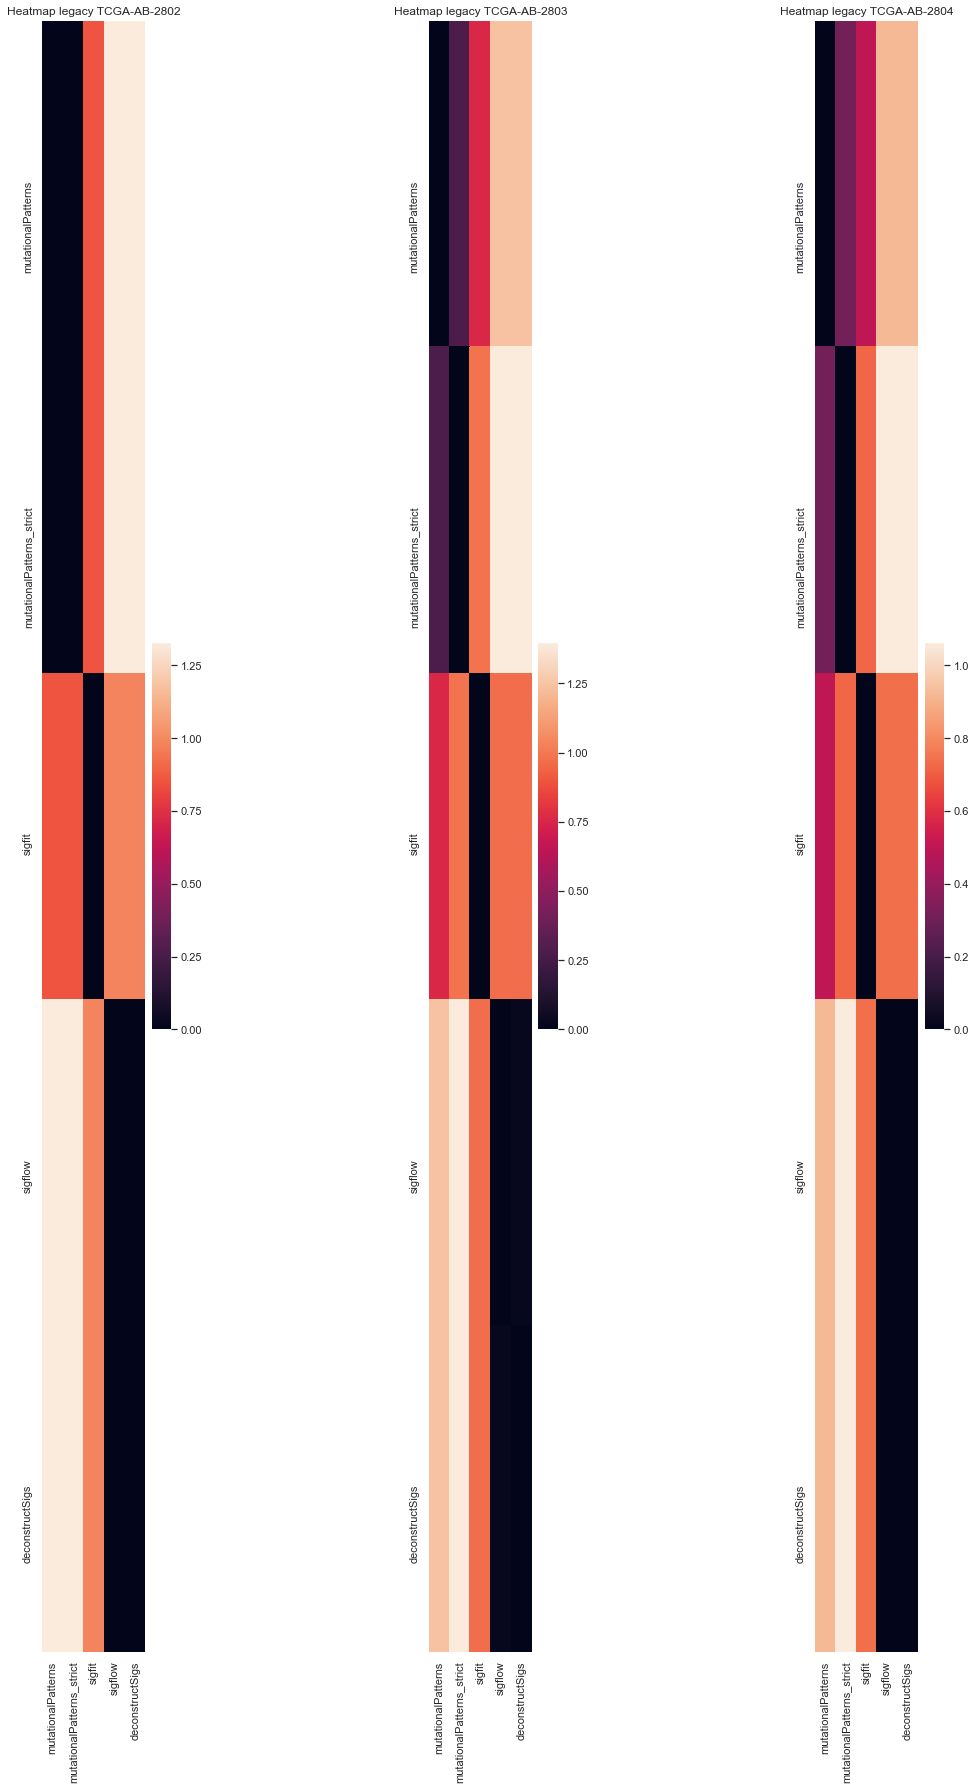

In [18]:
sigflow_legacy_exposure_df = pd.read_csv(r_output_file_dir + "/sigflow/legacy_fitting_relative_exposure.csv")

pie_chart_rows = math.ceil(sigflow_legacy_exposure_df.shape[0] / 3) 
pie_chart_cols = 3


mutationalPatterns_legacy_exposure_df = pd.read_csv(r_output_file_dir + "/mutational_patterns_results/legacy_sample_exposures.csv")
mutationalPatterns_legacy_exposure_df = mutationalPatterns_legacy_exposure_df.rename(columns={"Unnamed: 0": "sample"})
mutationalPatterns_legacy_exposure_df.set_index("sample", inplace = True)
mutationalPatterns_legacy_exposure_df = mutationalPatterns_legacy_exposure_df.div(mutationalPatterns_legacy_exposure_df.sum(axis=1), axis=0)
mutationalPatterns_legacy_exposure_df.reset_index(inplace= True)

mutationalPatterns_strict_legacy_exposure_df = pd.read_csv(r_output_file_dir + "/mutational_patterns_results/legacy_strict_sample_exposures.csv")
mutationalPatterns_strict_legacy_exposure_df = mutationalPatterns_strict_legacy_exposure_df.rename(columns={"Unnamed: 0": "sample"})
mutationalPatterns_strict_legacy_exposure_df.set_index("sample", inplace = True)
mutationalPatterns_strict_legacy_exposure_df = mutationalPatterns_strict_legacy_exposure_df.div(mutationalPatterns_strict_legacy_exposure_df.sum(axis=1), axis=0)
mutationalPatterns_strict_legacy_exposure_df.reset_index(inplace= True)

deconstructSigs_legacy_exposure_df = pd.read_csv(r_output_file_dir + "/deconstructsigs_results/legacy_sample_exposures.csv")
deconstructSigs_legacy_exposure_df.rename( columns = {"Unnamed: 0": "sample"}, inplace= True)

sigfit_legacy_exposure_df = pd.read_csv(r_output_file_dir + "/sigfit_results/sample_exposures_legacy.csv")
sigfit_legacy_exposure_df.rename(columns={"Unnamed: 0": "sample" }, inplace= True)
sigfit_legacy_exposure_df.columns = ["sample"] +  [ "COSMIC_" + i.split(".")[-1] for i in sigfit_legacy_exposure_df.columns[1:]]

legacy_df_list = [ mutationalPatterns_legacy_exposure_df.sort_values(by=["sample"]).iloc[2:5,:] , mutationalPatterns_strict_legacy_exposure_df.sort_values(by=["sample"]).iloc[2:5,:] ,  sigfit_legacy_exposure_df.sort_values(by=["sample"]).iloc[2:5,:], sigflow_legacy_exposure_df.sort_values(by=["sample"]).iloc[2:5,:] ,  deconstructSigs_legacy_exposure_df.sort_values(by=["sample"]).iloc[2:5,:] ]
legacy_df_name_list = ["mutationalPatterns", "mutationalPatterns_strict",  "sigfit" , "sigflow" ,  "deconstructSigs"]
distance_df_list = []
for i in range(legacy_df_list[0].shape[0]):
    temp_df = []
    for index , j in enumerate(legacy_df_list):
        j.iloc[i,0] = legacy_df_name_list[index]
        temp_df.append(list(j.iloc[i,:]))
    _df = pd.DataFrame(temp_df, columns = legacy_df_list[0].columns)
    _df.fillna(0, inplace = True)
    distance_df_list.append(_df)

fig = plt.figure(figsize=(30, 30))
fig.subplots_adjust(hspace=2, wspace=2)
rows = 1
columns = 5
for i in range(len(distance_df_list)):
    df = distance_df_list[i]
    df__ = pd.DataFrame(squareform(pdist(df.iloc[:, 1:])), columns=df["sample"].unique(), index=df["sample"].unique())
    sns.set()
    ax = fig.add_subplot(rows, columns, i+1)    
    sns.heatmap(df__)
    plt.title("Heatmap legacy " + sigfit_legacy_exposure_df.iloc[i,0] )

plt.savefig(r_output_file_dir + "/Heatmap_legacy_mutationalpatterns.pdf", dpi =500)


# legacy_df_list = [ mutationalPatterns_legacy_exposure_df.sort_values(by=["sample"]).iloc[2:5,:]]
# legacy_df_name_list = [ "mutationalPatterns"]
# fig = plt.figure(figsize=( 120, 30 ))
# fig.subplots_adjust(right = 0.9, wspace=.01)
# rows = 1
# columns = 1
# print("bop")

# for i in range(len(legacy_df_list)):
#     df = legacy_df_list[i]
#     sns.set()
#     ax = fig.add_subplot(rows, columns, i+1)    
#     sns.heatmap(df.set_index("sample") , cmap="YlGnBu" , xticklabels = True, yticklabels= True)
#     sns.set(rc={'figure.figsize':(30, 30)})
#     plt.title("Heatmap legacy " + legacy_df_name_list[i] )
# plt.savefig(r_output_file_dir + "/Heatmap_exposures_all_sigs_legacy_mutationalpatterns.pdf")


In [19]:
mutationalPatterns_sbs_exposure_df.sort_values(by=["sample"]).iloc[2:5,:]

,sample,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,SBS7b,SBS7c,...,SBS41,SBS42,SBS44,SBS84,SBS85,SBS86,SBS87,SBS88,SBS89,SBS90
2,TCGA-AB-2804,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.053608,0.0,0.000000,0.0,0.0
3,TCGA-AB-2805,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.731340,0.0,0.000000,0.0,0.0
4,TCGA-AB-2806,0.0,0.0,0.0,0.129942,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.256322,0.0,0.193862,0.0,0.0


1 5


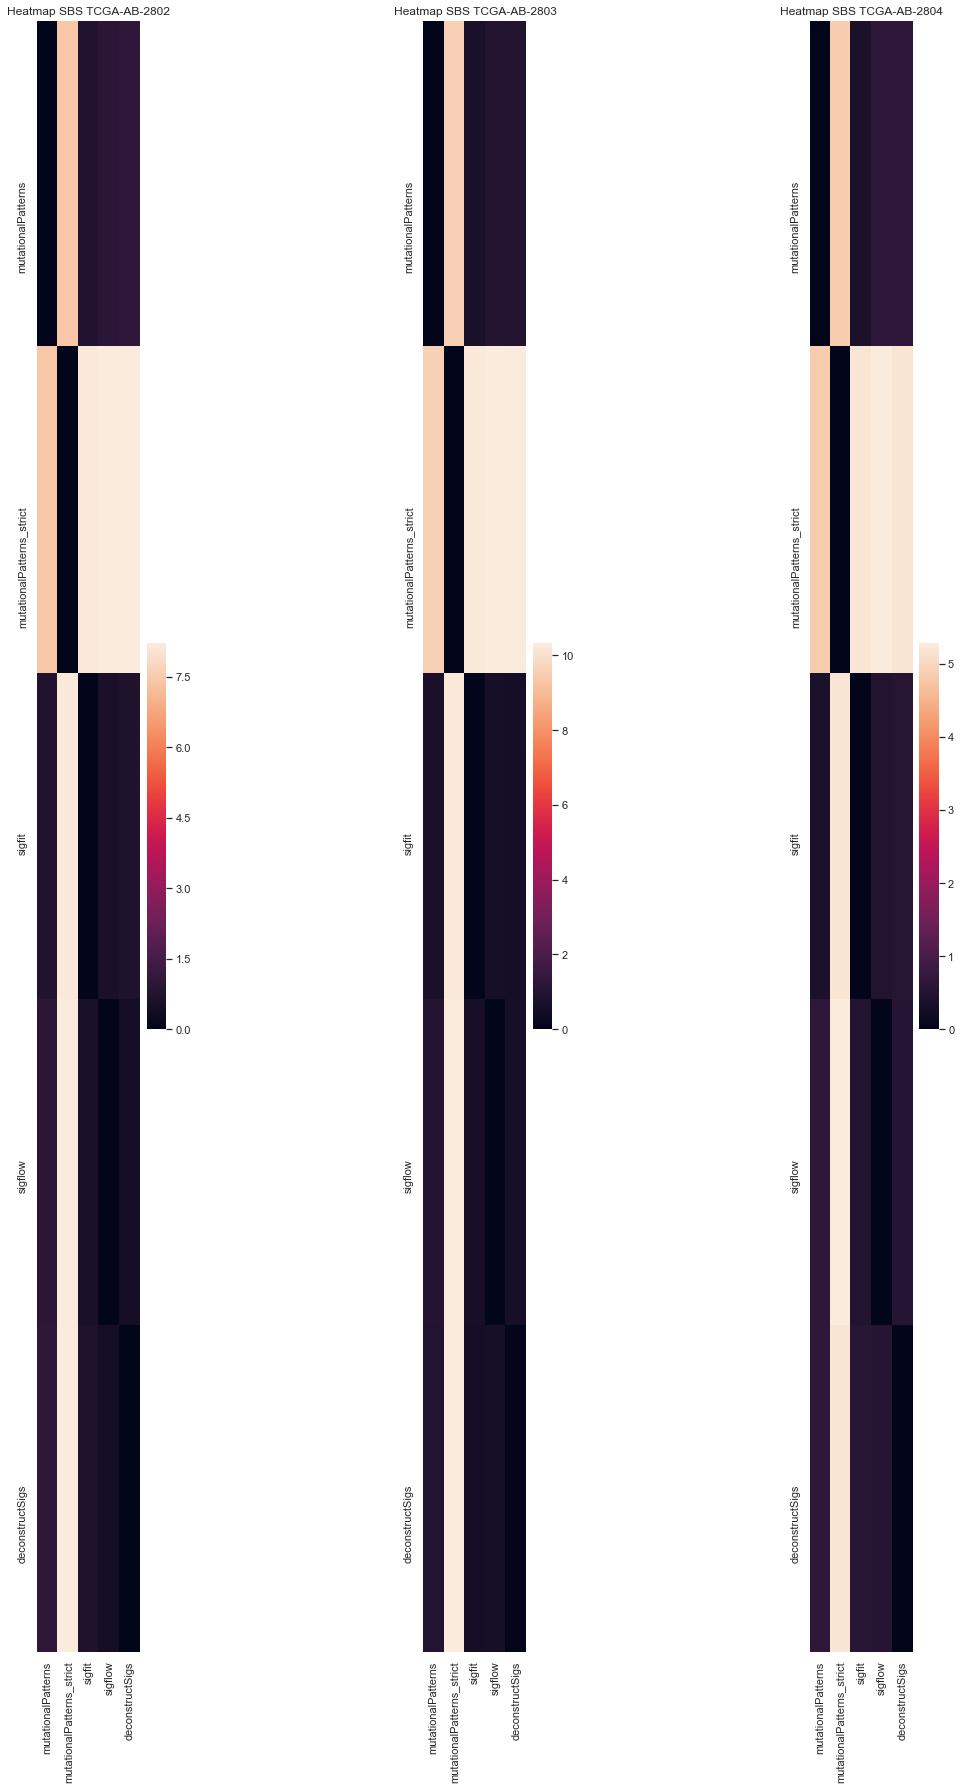

In [17]:

sigflow_sbs_exposure_df = pd.read_csv(r_output_file_dir + "/sigflow/SBS_fitting_relative_exposure.csv")
pie_chart_rows = math.ceil(sigflow_sbs_exposure_df.shape[0] / 3) 
pie_chart_cols = 3

mutationalPatterns_sbs_exposure_df = pd.read_csv(r_output_file_dir + "/mutational_patterns_results/sample_exposures.csv")
mutationalPatterns_sbs_exposure_df = mutationalPatterns_sbs_exposure_df
mutationalPatterns_sbs_exposure_df.rename(columns={"Unnamed: 0": "sample"}, inplace = True)
mutationalPatterns_sbs_exposure_df.set_index("sample", inplace = True)
mutationalPatterns_sbs_exposure_df = mutationalPatterns_sbs_exposure_df.rename(columns={"index": "sample"})
mutationalPatterns_sbs_exposure_df.sum(axis=1)
mutationalPatterns_sbs_exposure_df = mutationalPatterns_sbs_exposure_df.div(mutationalPatterns_sbs_exposure_df.sum(axis=1), axis=0)
mutationalPatterns_sbs_exposure_df.reset_index(inplace= True)

mutationalPatterns_strict_sbs_exposure_df = pd.read_csv(r_output_file_dir + "/mutational_patterns_results/strict_sample_exposures.csv")
mutationalPatterns_strict_sbs_exposure_df = mutationalPatterns_strict_sbs_exposure_df
mutationalPatterns_strict_sbs_exposure_df.rename(columns={"Unnamed: 0": "sample"}, inplace = True)
mutationalPatterns_strict_sbs_exposure_df.set_index("sample", inplace = True)
mutationalPatterns_strict_sbs_exposure_df = mutationalPatterns_strict_sbs_exposure_df.rename(columns={"index": "sample"})
mutationalPatterns_strict_sbs_exposure_df.sum(axis=1)
mutationalPatterns_strict_sbs_exposure_df.div(mutationalPatterns_strict_sbs_exposure_df.sum(axis=1), axis=0)
mutationalPatterns_strict_sbs_exposure_df.reset_index(inplace= True)

deconstructSigs_sbs_exposure_df = pd.read_csv(r_output_file_dir + "/deconstructsigs_results/sbs_sample_exposures.csv")
deconstructSigs_sbs_exposure_df.rename( columns = {"Unnamed: 0": "sample"}, inplace= True)

sigfit_sbs_exposure_df = pd.read_csv(r_output_file_dir + "/sigfit_results/sample_exposures_sbs.csv")
sigfit_sbs_exposure_df.rename(columns={"Unnamed: 0": "sample" }, inplace= True)

sbs_df_list = [mutationalPatterns_sbs_exposure_df.sort_values(by=["sample"]).iloc[2:5,:], mutationalPatterns_strict_sbs_exposure_df.sort_values(by=["sample"]).iloc[2:5,:],  sigfit_sbs_exposure_df.sort_values(by=["sample"]).iloc[2:5,:], sigflow_sbs_exposure_df.sort_values(by=["sample"]).iloc[2:5,:], deconstructSigs_sbs_exposure_df.sort_values(by=["sample"]).iloc[2:5,:] ]
sbs_df_name_list = [ "mutationalPatterns", "mutationalPatterns_strict" ,  "sigfit" , "sigflow" , "deconstructSigs"]
distance_df_list = []
for i in range(sbs_df_list[0].shape[0]):
    temp_df = []
    for index , j in enumerate(sbs_df_list):
        j["sample"] = sbs_df_name_list[index]
        temp_df.append(list(j.iloc[i,:]))
    _df = pd.DataFrame(temp_df, columns = sbs_df_list[3].columns)
    _df.fillna(0, inplace= True)
    distance_df_list.append(_df)

fig = plt.figure(figsize=(30, 30))
fig.subplots_adjust(hspace=2, wspace=2)
rows = 1 
columns = 5
print(rows, columns)
for i in range(len(distance_df_list)):  
    df = distance_df_list[i]
    df_ = pd.DataFrame(squareform(pdist(df.iloc[:, 1:])), columns=df["sample"].unique(), index=df["sample"].unique())
    sns.set()
    ax = fig.add_subplot(rows, columns, i+1)    
    sns.heatmap(df_)
    plt.title("Heatmap SBS " + str(sigfit_sbs_exposure_df.iloc[i,0]))
plt.savefig(r_output_file_dir + "/Heatmap_SBS_mutational_patterns.pdf", dpi =500)


# sbs_df_list = [mutationalPatterns_sbs_exposure_df.sort_values(by=["sample"]).iloc[2:5,:] ]
# sbs_df_name_list = [ "mutationalPatters"]
# fig = plt.figure(figsize=(120, 30))
# fig.subplots_adjust(right = 0.9, wspace=.01)
# rows = 1
# columns = 4
# for i in range(len(sbs_df_list)):  
#     df = sbs_df_list[i].set_index("sample").astype(float)
#     sns.set()
#     ax = fig.add_subplot(rows, columns, i+1)
#     sns.heatmap(df , cmap="YlGnBu", xticklabels = True, yticklabels= True )
#     sns.set(rc={'figure.figsize':(30, 30)})
#     plt.title("Heatmap SBS " + str(sbs_df_name_list[i]))
# plt.savefig(r_output_file_dir + "/Heatmap_exposures_all_sigs_SBS_mutationalpattern.pdf")


In [ ]:
run_legacy(sigfit = False)

32 6


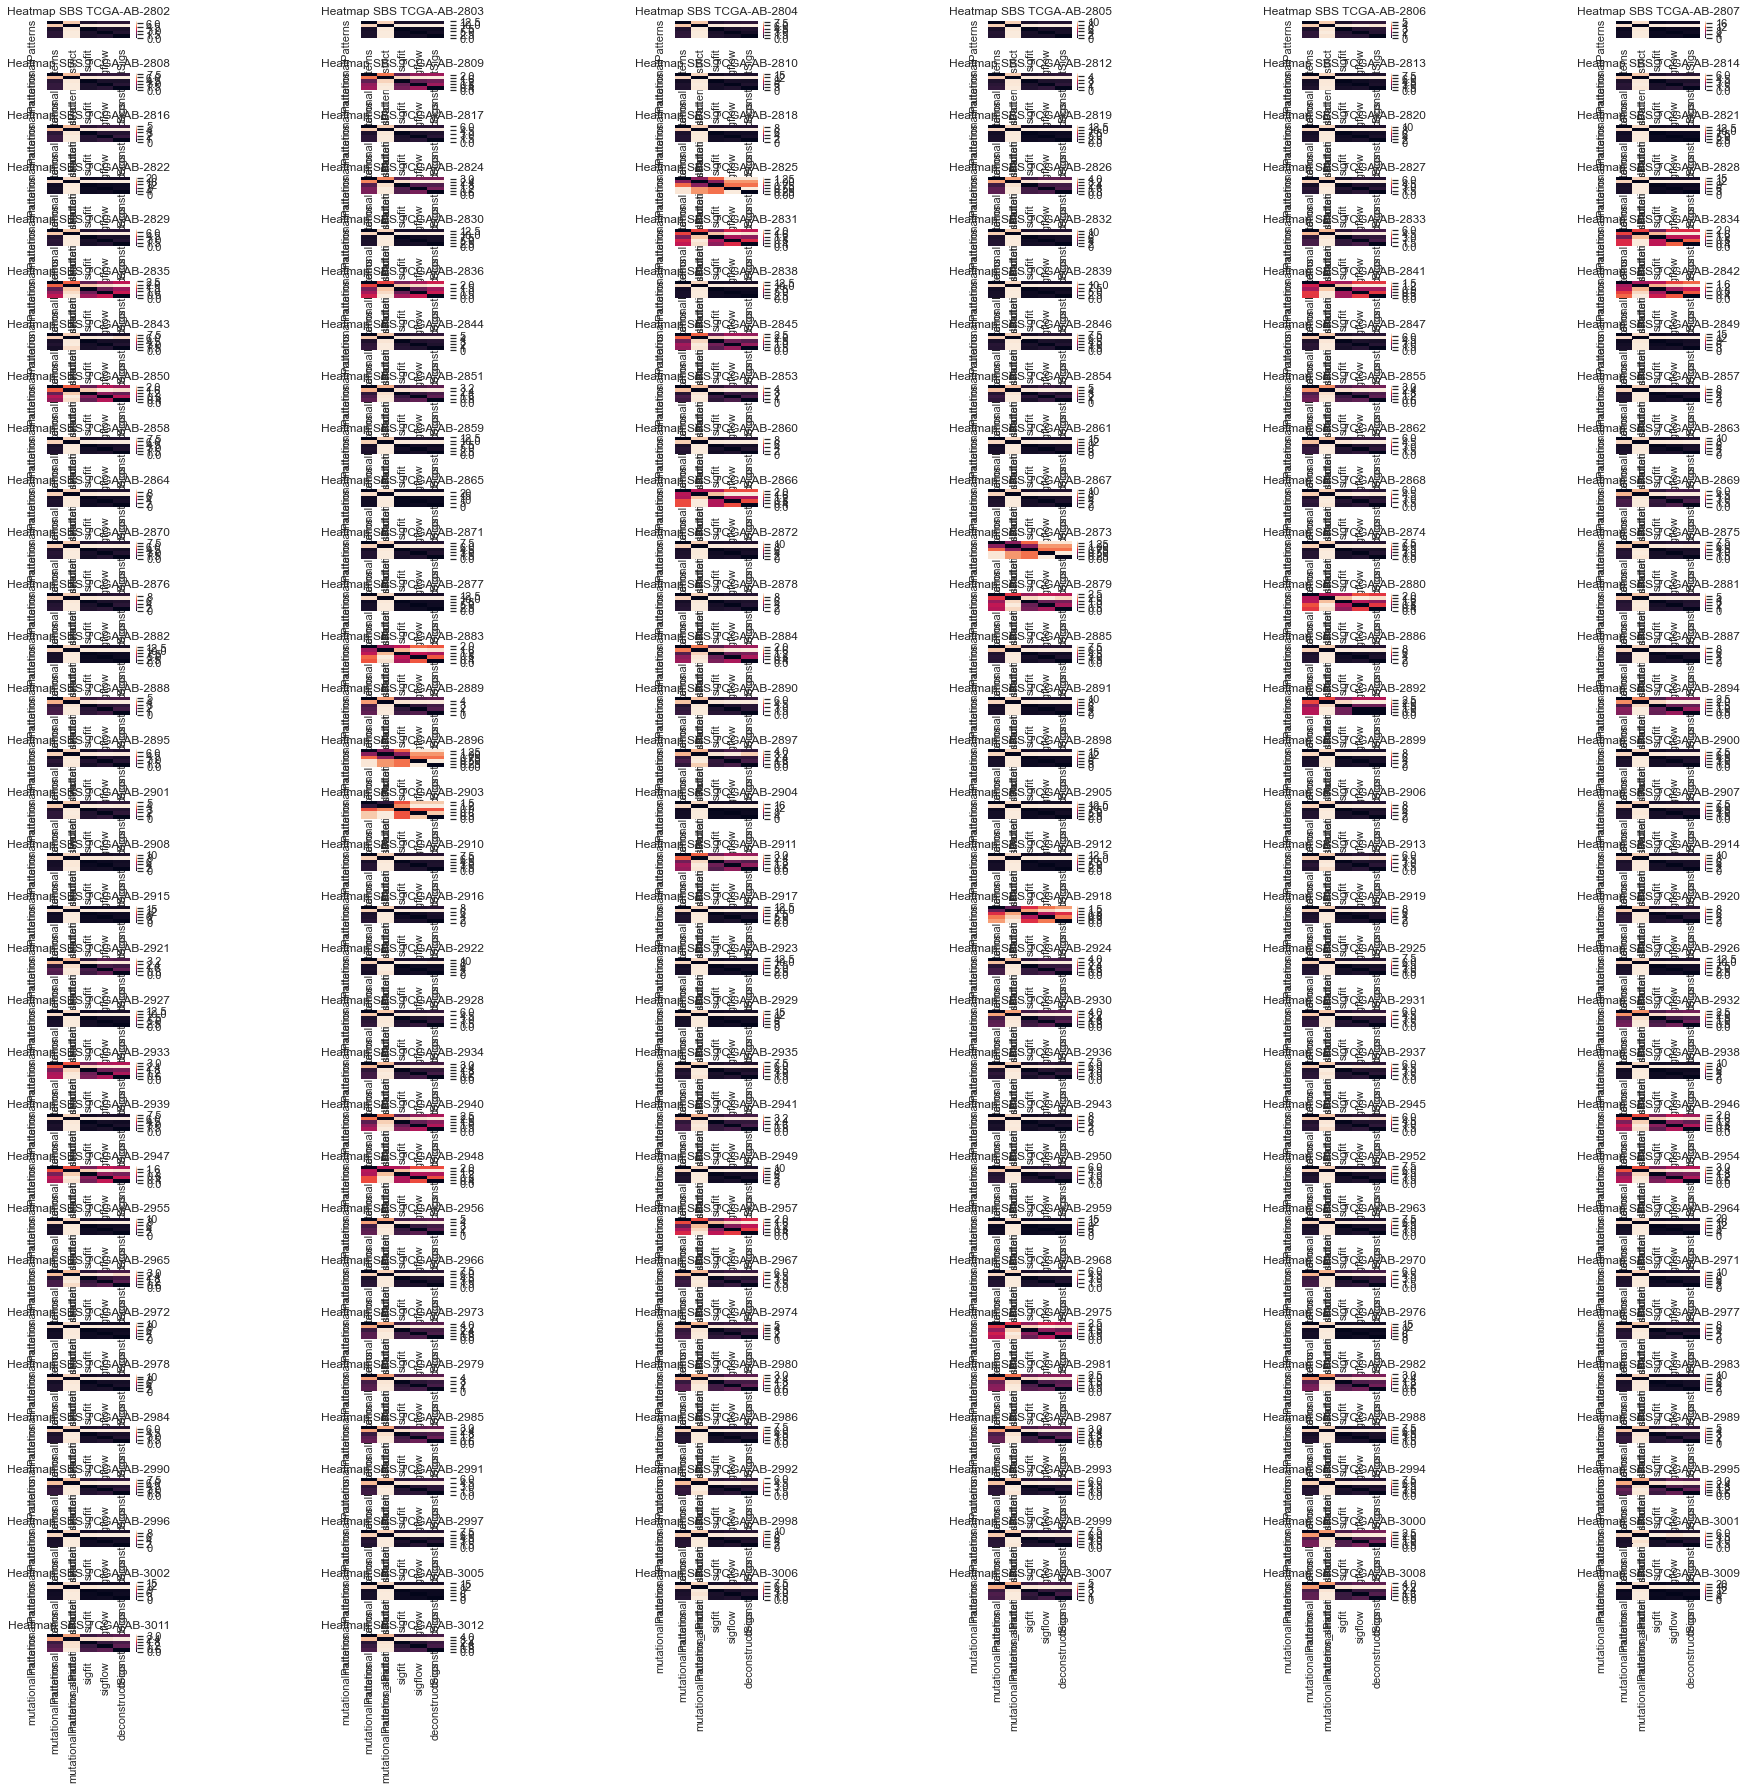

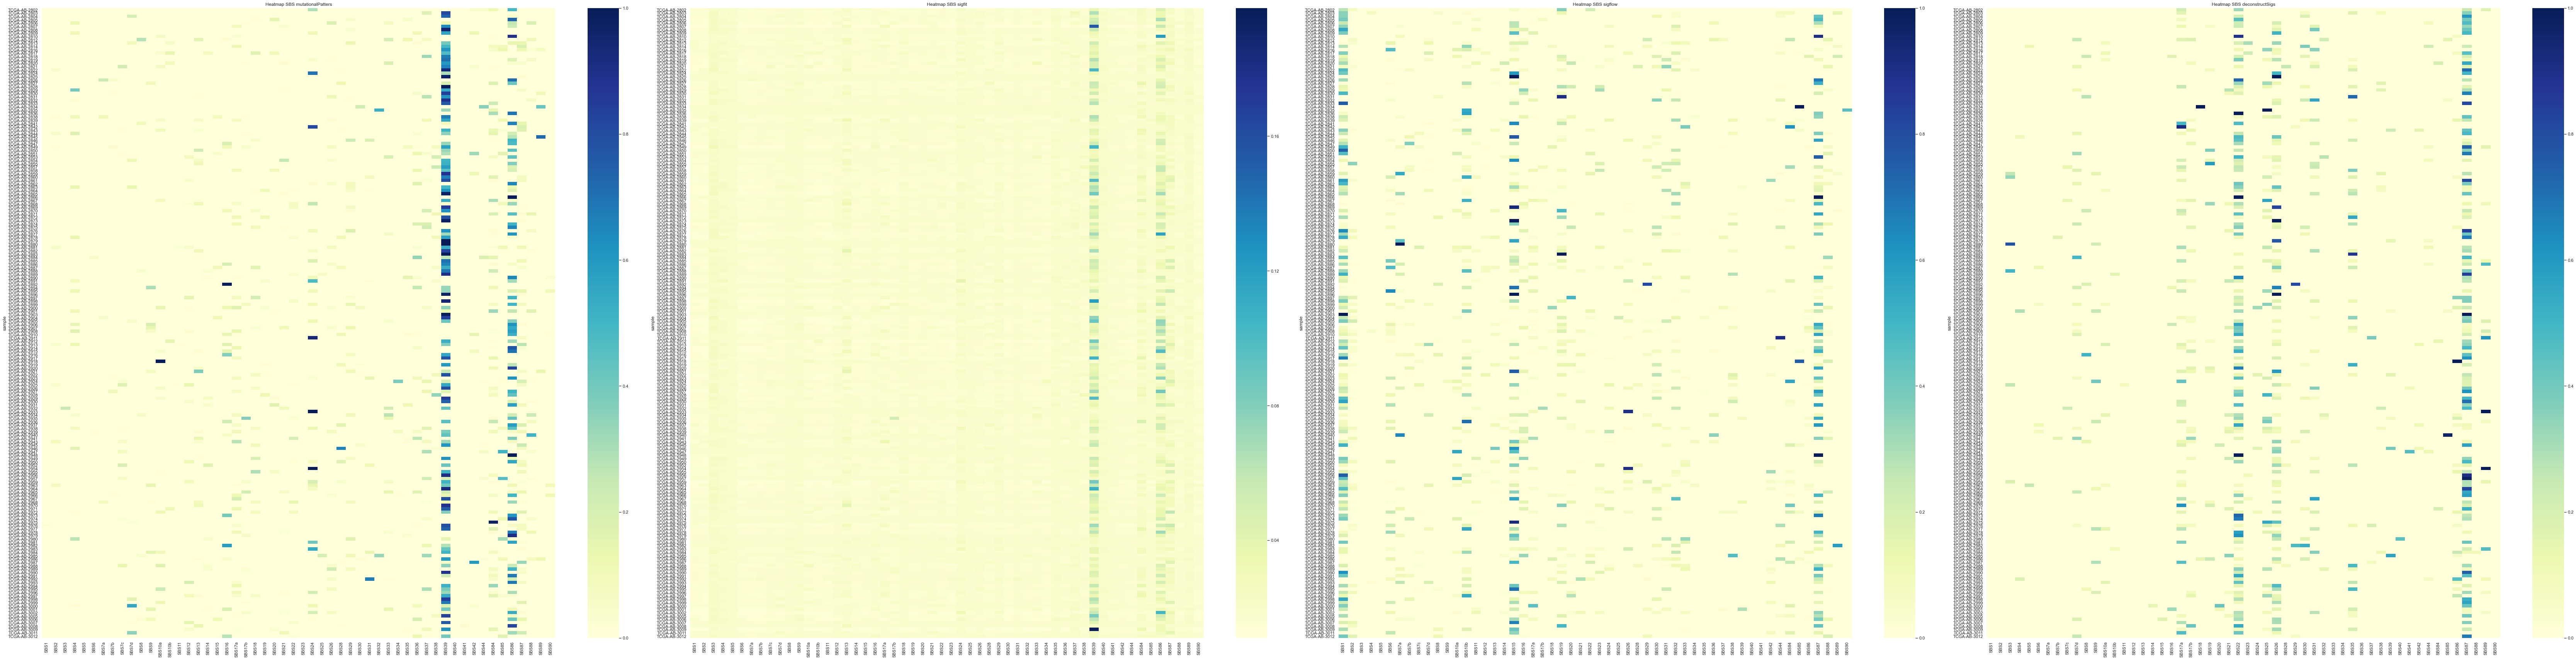

In [2]:
run_sbs()

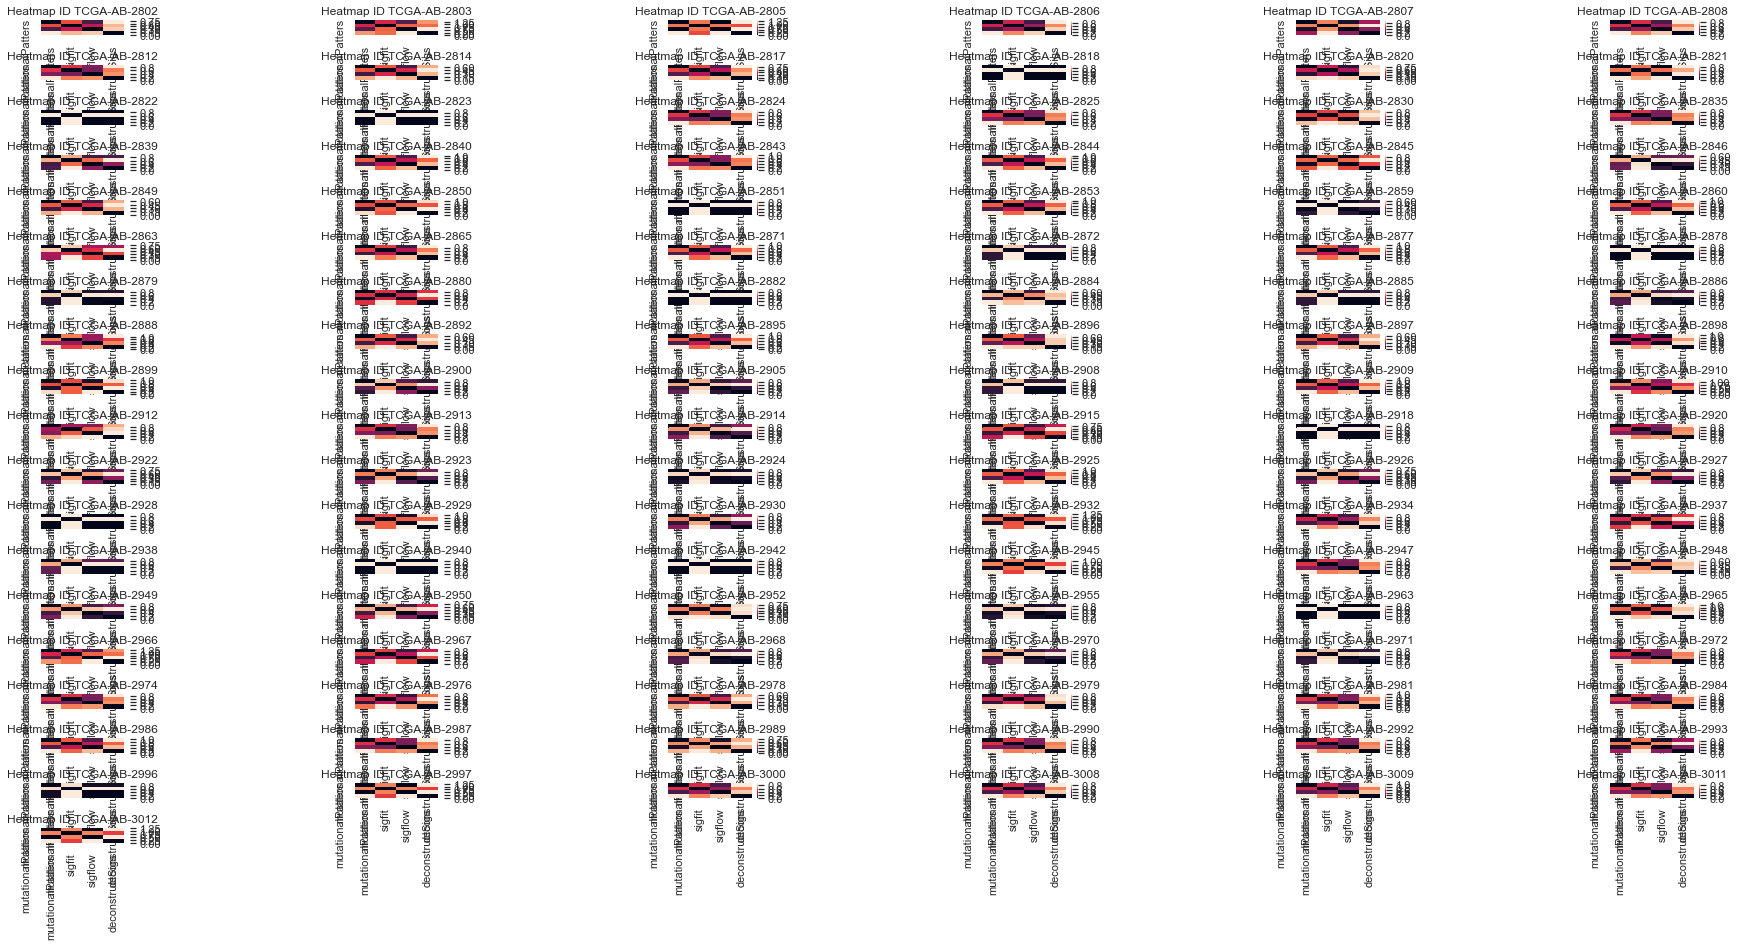

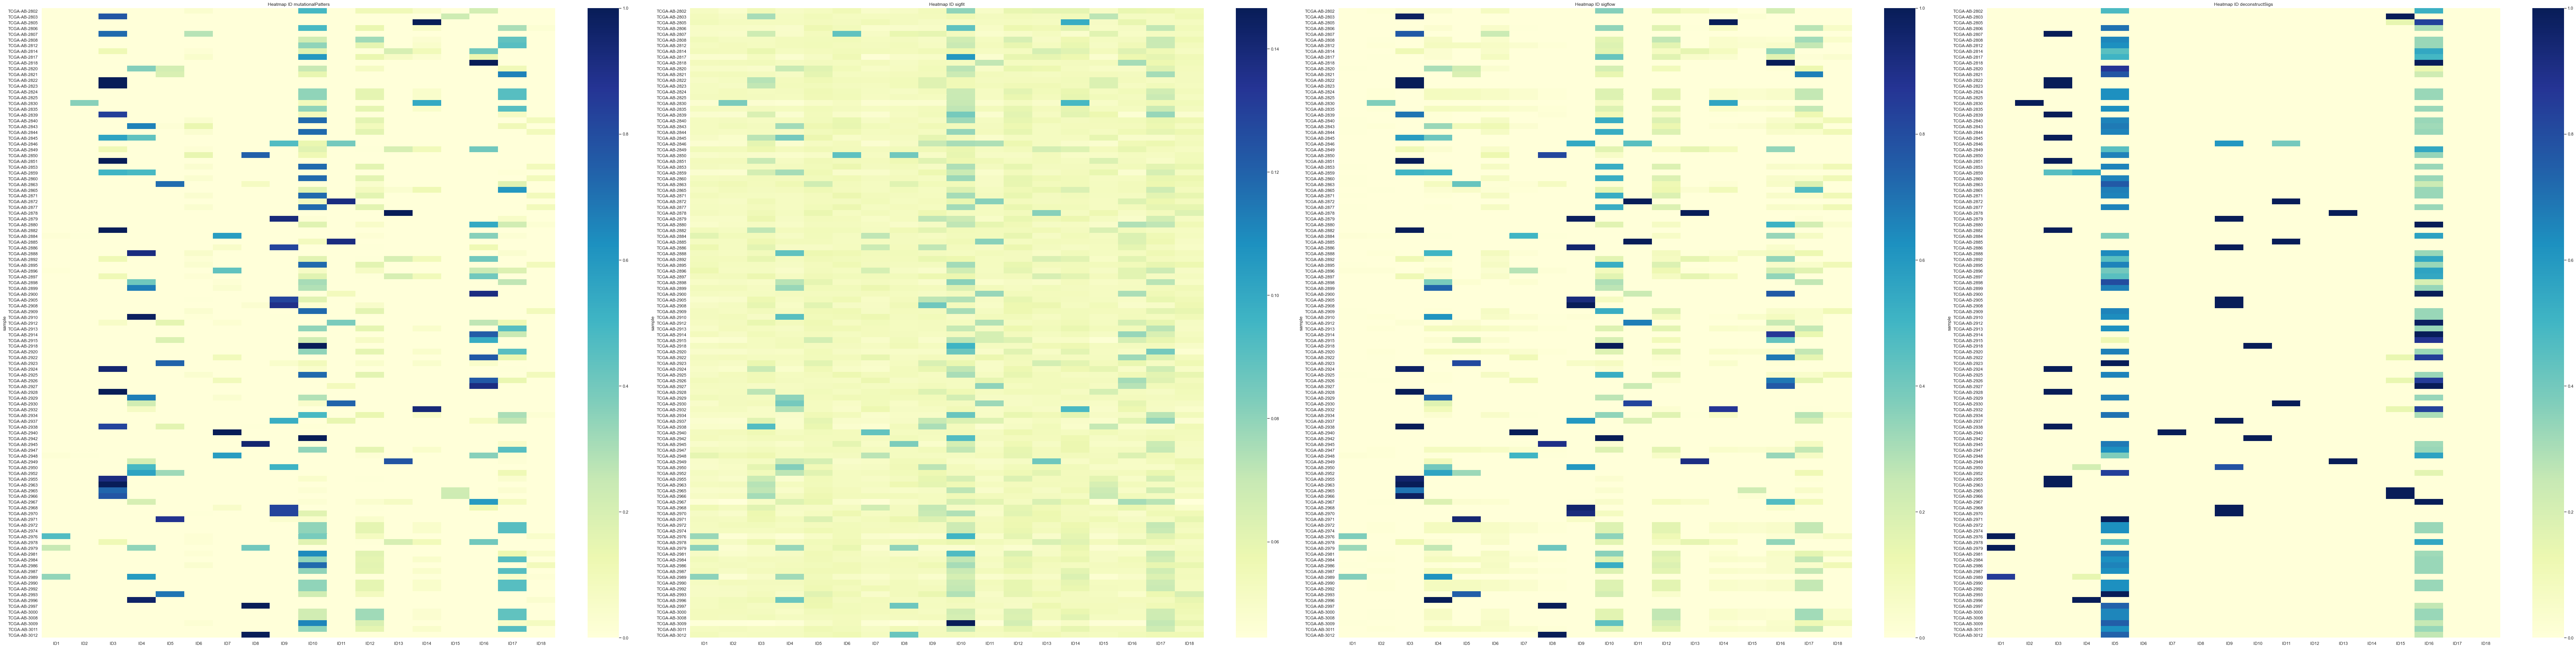

In [45]:
run_id()

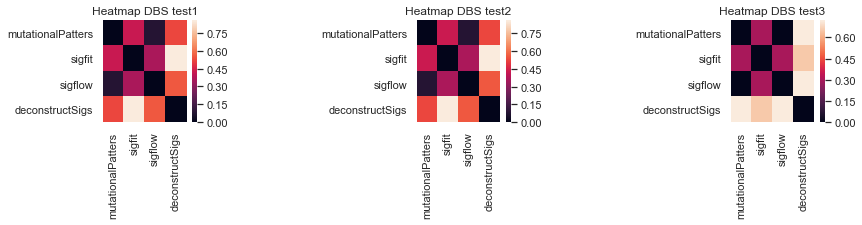

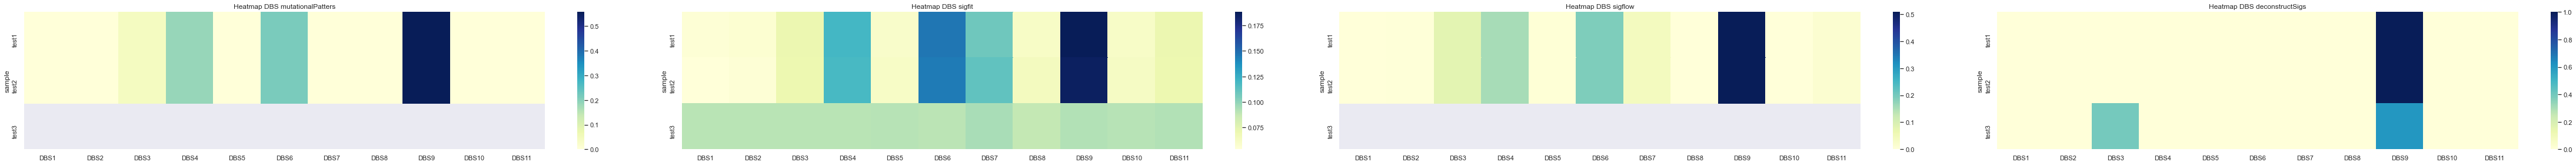

In [24]:
run_dbs()